# A/B testing about marketing effectiveness

Background: 

data source https://www.kaggle.com/datasets/faviovaz/marketing-ab-testing

Marketing companies want to run successful campaigns, but the market is complex and several options can work. So normally they tun A/B tests, that is a randomized experimentation process wherein two or more versions of a variable (web page, page element, banner, etc.) are shown to different segments of people at the same time to determine which version leaves the maximum impact and drive business metrics.

The companies are interested in answering two questions:

Would the campaign be successful?
If the campaign was successful, how much of that success could be attributed to the ads?
With the second question in mind, we normally do an A/B test. The majority of the people will be exposed to ads (the experimental group). And a small portion of people (the control group) would instead see a Public Service Announcement (PSA) (or nothing) in the exact size and place the ad would normally be.

The idea of the dataset is to analyze the groups, find if the ads were successful, how much the company can make from the ads, and if the difference between the groups is statistically significant.

Data dictionary:

Index: Row index
user id: User ID (unique)
test group: If "ad" the person saw the advertisement, if "psa" they only saw the public service announcement
converted: If a person bought the product then True, else is False
total ads: Amount of ads seen by person
most ads day: Day that the person saw the biggest amount of ads
most ads hour: Hour of day that the person saw the biggest amount of ads

# 1. Import packages and set styles

In [84]:
# Packages imports
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.stats.api as sms
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

# Jupyter Notebooks are great for working with python, but, by default, the cells will only output the last expression.
# But you can use the following commands to see all the outputs from all commands within the same cell 
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# The line magic command enables the drawing of matplotlib figures in the IPython environment. Once this command is executed in any cell, the matplotlib plots will appear directly below the cell in which the plot function was called for the rest of the session.
%matplotlib inline 

# plot styling preferences
plt.style.use('seaborn-whitegrid')
font = {'family' : 'Helvetica',
        'weight' : 'bold',
        'size'   : 14}

mpl.rc('font', **font)

# 2. Read data 

In [18]:
# Read data 
# data downloaded from https://www.kaggle.com/datasets/faviovaz/marketing-ab-testing
marketAB = pd.read_csv('marketing_AB.csv')

# 3. Overview the data and clean up if needed 

In [95]:
# Take a look at the data 
# See some basic functions for pandas: https://www.analyticsvidhya.com/blog/2022/07/pandas-functions-you-should-

type(marketAB) # data type

marketAB.info()

marketAB.describe()

marketAB.nunique()

marketAB.corr()

marketAB.head()
# test group: If "ad" the person saw the advertisement, if "psa" they only saw the public service announcement;
# converted: If a person bought the product then True, else is False

marketAB.tail()

marketAB.isnull()

marketAB.loc[100,'user id']

marketAB.iloc[[100,200],[1,2,3]]

marketAB["test group"].unique()

marketAB["user id"].nunique()

marketAB[marketAB["converted"].isnull()]

marketAB["test group"].value_counts()

# list(marketAB.index) # see what's the index for each entry of the data frame 

marketAB.cross= pd.crosstab(marketAB['converted'], marketAB['test group'])
marketAB.cross

# for test group = 'ad', calculate the rate of convertion from false to true
marketAB.cross.loc[1, 'ad']/(marketAB.cross.loc[0, 'ad']+marketAB.cross.loc[1, 'ad'])

# for test group = 'psa', calculate the rate of convertion from false to true
marketAB.cross.loc[1, 'psa']/(marketAB.cross.loc[0, 'psa']+marketAB.cross.loc[1, 'psa'])


pandas.core.frame.DataFrame

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 588101 entries, 0 to 588100
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Unnamed: 0     588101 non-null  int64 
 1   user id        588101 non-null  int64 
 2   test group     588101 non-null  object
 3   converted      588101 non-null  bool  
 4   total ads      588101 non-null  int64 
 5   most ads day   588101 non-null  object
 6   most ads hour  588101 non-null  int64 
dtypes: bool(1), int64(4), object(2)
memory usage: 27.5+ MB


,Unnamed: 0,user id,total ads,most ads hour
count,588101.000000,5.881010e+05,588101.000000,588101.000000
mean,294050.000000,1.310692e+06,24.820876,14.469061
std,169770.279667,2.022260e+05,43.715181,4.834634
min,0.000000,9.000000e+05,1.000000,0.000000
25%,147025.000000,1.143190e+06,4.000000,11.000000
50%,294050.000000,1.313725e+06,13.000000,14.000000
75%,441075.000000,1.484088e+06,27.000000,18.000000
max,588100.000000,1.654483e+06,2065.000000,23.000000


Unnamed: 0       588101
user id          588101
test group            2
converted             2
total ads           807
most ads day          7
most ads hour        24
dtype: int64

,Unnamed: 0,user id,converted,total ads,most ads hour
Unnamed: 0,1.000000,-0.037463,-0.104192,-0.389108,0.006232
user id,-0.037463,1.000000,0.000635,0.012336,-0.023002
converted,-0.104192,0.000635,1.000000,0.217419,0.019674
total ads,-0.389108,0.012336,0.217419,1.000000,-0.010837
most ads hour,0.006232,-0.023002,0.019674,-0.010837,1.000000


,Unnamed: 0,user id,test group,converted,total ads,most ads day,most ads hour
0,0,1069124,ad,False,130,Monday,20
1,1,1119715,ad,False,93,Tuesday,22
2,2,1144181,ad,False,21,Tuesday,18
3,3,1435133,ad,False,355,Tuesday,10
4,4,1015700,ad,False,276,Friday,14


,Unnamed: 0,user id,test group,converted,total ads,most ads day,most ads hour
588096,588096,1278437,ad,False,1,Tuesday,23
588097,588097,1327975,ad,False,1,Tuesday,23
588098,588098,1038442,ad,False,3,Tuesday,23
588099,588099,1496395,ad,False,1,Tuesday,23
588100,588100,1237779,ad,False,1,Tuesday,23


,Unnamed: 0,user id,test group,converted,total ads,most ads day,most ads hour
0,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...
588096,False,False,False,False,False,False,False
588097,False,False,False,False,False,False,False
588098,False,False,False,False,False,False,False
588099,False,False,False,False,False,False,False


1142414

,user id,test group,converted
100,1142414,ad,False
200,1058604,ad,False


array(['ad', 'psa'], dtype=object)

588101

,Unnamed: 0,user id,test group,converted,total ads,most ads day,most ads hour


ad     564577
psa     23524
Name: test group, dtype: int64

test group,ad,psa
converted,,
False,550154,23104
True,14423,420


0.025546559636683747

0.01785410644448223

# 4. Calculate the sample size required for the specific statistical power

In [63]:
# Calculating effect size based on our expected rates
effect_size = sms.proportion_effectsize(0.01, 0.03)    

In [64]:
effect_size

-0.14783117894984127

In [65]:
# Now we need to calculate the sample size needed to achieve power 80%
required_n = sms.NormalIndPower().solve_power(
    effect_size, 
    power=0.8, 
    alpha=0.05, 
    ratio=1) 

# Power of the test (1 — β) — This represents the probability of finding a statistical difference between the groups in our test when a difference is actually present. This is usually set at 0.8 by convention (here’s more info on statistical power, if you are curious)

required_n = ceil(required_n) # Rounding up to next whole number                          

print(required_n)

719


# 5. Sampling
Given that our DataFrame is nice and clean now, we can proceed and sample a certain entries for each of the groups.

In [96]:
# set resample size 
resample_n = 20000 # I chose this number because it is larger than the required_n = 4720, and is smaller than the "psa" test group number = 23524

control_sample = marketAB[marketAB["test group"]=='psa'].sample(n = resample_n, random_state = 123)
control_sample

ad_sample = marketAB[marketAB["test group"]=='ad'].sample(n = resample_n, random_state = 123)
ad_sample

AB_resample = pd.concat([control_sample, ad_sample], axis = 0)
AB_resample.reset_index(drop = True, inplace = True)
AB_resample

AB_resample.info()
AB_resample['test group'].value_counts()

,Unnamed: 0,user id,test group,converted,total ads,most ads day,most ads hour
66984,66984,902304,psa,False,34,Saturday,15
164171,164171,920817,psa,False,50,Wednesday,20
559349,559349,922271,psa,False,2,Wednesday,16
390032,390032,922604,psa,False,12,Saturday,2
30349,30349,905054,psa,False,41,Friday,18
...,...,...,...,...,...,...,...
63476,63476,922079,psa,False,66,Sunday,14
29133,29133,907553,psa,False,16,Sunday,13
318515,318515,916861,psa,False,15,Monday,15
153458,153458,903076,psa,False,13,Wednesday,16


,Unnamed: 0,user id,test group,converted,total ads,most ads day,most ads hour
376440,376440,1386643,ad,False,8,Tuesday,20
17219,17219,1173044,ad,False,9,Wednesday,9
528723,528723,1059466,ad,False,7,Friday,17
191228,191228,1249381,ad,False,36,Saturday,12
223954,223954,1629123,ad,False,6,Friday,9
...,...,...,...,...,...,...,...
151264,151264,1609632,ad,False,29,Wednesday,13
202460,202460,1383014,ad,False,26,Wednesday,10
373988,373988,1191547,ad,True,63,Tuesday,21
243018,243018,1321009,ad,False,12,Sunday,8


,Unnamed: 0,user id,test group,converted,total ads,most ads day,most ads hour
0,66984,902304,psa,False,34,Saturday,15
1,164171,920817,psa,False,50,Wednesday,20
2,559349,922271,psa,False,2,Wednesday,16
3,390032,922604,psa,False,12,Saturday,2
4,30349,905054,psa,False,41,Friday,18
...,...,...,...,...,...,...,...
39995,151264,1609632,ad,False,29,Wednesday,13
39996,202460,1383014,ad,False,26,Wednesday,10
39997,373988,1191547,ad,True,63,Tuesday,21
39998,243018,1321009,ad,False,12,Sunday,8


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Unnamed: 0     40000 non-null  int64 
 1   user id        40000 non-null  int64 
 2   test group     40000 non-null  object
 3   converted      40000 non-null  bool  
 4   total ads      40000 non-null  int64 
 5   most ads day   40000 non-null  object
 6   most ads hour  40000 non-null  int64 
dtypes: bool(1), int64(4), object(2)
memory usage: 1.9+ MB


psa    20000
ad     20000
Name: test group, dtype: int64

In [97]:
# Replace TRUE TO 1, and FALSE WITH 0 for the column "converted"
AB_resample["converted"] = AB_resample["converted"].astype(int)
AB_resample['converted']

0        0
1        0
2        0
3        0
4        0
        ..
39995    0
39996    0
39997    1
39998    0
39999    0
Name: converted, Length: 40000, dtype: int32

# 6. Testing the hypothesis

In [98]:
control_results = AB_resample[AB_resample['test group'] == 'psa']['converted']
control_results
type(control_results)

treatment_results = AB_resample[AB_resample['test group'] == 'ad']['converted']
treatment_results


0        0
1        0
2        0
3        0
4        0
        ..
19995    0
19996    0
19997    0
19998    0
19999    0
Name: converted, Length: 20000, dtype: int32

pandas.core.series.Series

20000    0
20001    0
20002    0
20003    0
20004    0
        ..
39995    0
39996    0
39997    1
39998    0
39999    0
Name: converted, Length: 20000, dtype: int32

In [99]:
n_con = control_results.count()
n_con

n_treat = treatment_results.count()
n_treat

successes = [control_results.sum(), treatment_results.sum()]
successes

nobs = [n_con, n_treat]
nobs

20000

20000

[358, 516]

[20000, 20000]

In [101]:
z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval}')
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

z statistic: -5.40
p-value: 6.524652431269707e-08
ci 95% for control group: [0.016, 0.020]
ci 95% for treatment group: [0.024, 0.028]


# 7. Drawing conclusion
Since our p-value is way smaller than α=0.05 threshold, we can reject the Null hypothesis Hₒ, which means that our new "ad treatment did perform significantly different than "psa" treatment

Additionally, the confidence interval for the treatment group ([0.024, 0.028]) is significantly different than the CIs of the control group ([0.016, 0.020]).


# 8. Visualization 

In [105]:
conversion_rates = AB_resample.groupby('test group')['converted']

std_p = lambda x: np.std(x, ddof=0)  # Std. deviation of the proportion
se_p = lambda x: stats.sem(x, ddof=0)  # Std. error of the proportion (std / sqrt(n))

conversion_rates = conversion_rates.agg([np.mean, std_p, se_p])
conversion_rates.columns = ['conversion_rate', 'std_deviation', 'std_error']

conversion_rates.style.format('{:.3f}')

,conversion_rate,std_deviation,std_error
test group,,,
ad,0.026,0.159,0.001
psa,0.018,0.133,0.001


<Figure size 800x600 with 0 Axes>

<AxesSubplot:xlabel='test group', ylabel='converted'>

(0.0, 10.0)

Text(0.5, 1.0, 'Conversion rate by group')

Text(0.5, 0, 'Group')

Text(0, 0.5, 'Converted (%)')

Text(0.5, 8, '***')

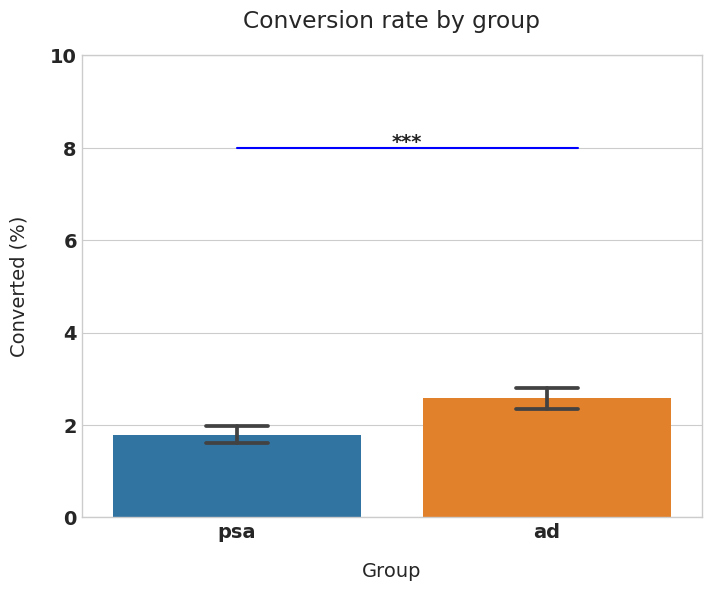

In [123]:
plt.figure(figsize=(8,6))

#draws error bars in the plot with 95% confidence interval.
sns.barplot(x=AB_resample['test group'], y=AB_resample['converted']*100, ci=95, capsize=.2)

plt.ylim(0, 10)
plt.title('Conversion rate by group', pad=20)
plt.xlabel('Group', labelpad=15)
plt.ylabel('Converted (%)', labelpad=15)
plt.text(x=0.5, y=8, s='***')
plt.axhline(y = 8, color = "b", linestyle = '-', xmin = 0.25, xmax = 0.8)
plt.show()